In [1]:
%config Completer.use_jedi = False

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import os.path

mpl.rcParams['figure.figsize'] = 12, 8
mpl.rcParams['font.size'] = 18

## Load sea ice data

In [23]:
ddir = '/home/disk/eos15/apauling/seaice'
dfile = 'CCSM41degcont.cice.h.aice.0071-0100avg.nc'
ncF = os.path.join(ddir, dfile)
ds = xr.open_dataset(ncF)

aice = ds['aice'].squeeze()

## CICE output plotting issue
### `Cartopy` doesn't like the grid from CICE output because the lat and lon arrays have NaNs. We can get around this by substituting the POP grid into the aice DataArray, since its the same grid, but for some reason POP doesn't put NaNs where there is land

## Load SST data

In [3]:
dfileS = 'CCSM41degcont.pop.h.SST.0071-0100avg.nc'
ncS = os.path.join(ddir, dfileS)
dsS = xr.open_dataset(ncS)

poplat = dsS.TLAT.data
poplon = dsS.TLONG.data

## Substitute POP lat and lon into CICE output

In [24]:
aice.TLAT[:] = poplat
aice.TLON[:] = poplon

## Now make a pretty pcolor plot of Arctic sea ice concentration

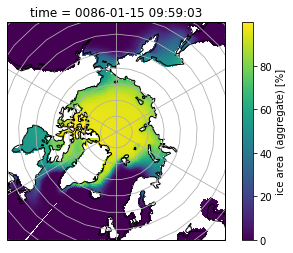

In [5]:
fig = plt.figure(1)
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.gridlines()
axs.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
im = aice.plot.pcolormesh('TLON', 'TLAT', ax=axs, transform=ccrs.PlateCarree())

## Wonderful. Now make a pretty pcolor plot of Antarctic sea ice concentration

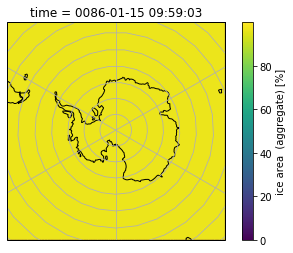

In [6]:
fig2 = plt.figure(2)
axs = plt.axes(projection=ccrs.SouthPolarStereo())
axs.coastlines()
axs.gridlines()
axs.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
im = aice.plot.pcolormesh('TLON', 'TLAT', ax=axs, transform=ccrs.PlateCarree())

## Oh dear

### There is a bug in `cartopy` where plotting data on a displaced pole grid like CICE or POP doesn't work in a South Polar Stereographic projection. I have opened a GitHub issue about it, so maybe this will be fixed soon.  
### In the meantime we can get around it by excluding some Northern Hemisphere points around the "pole hole"  

### After some messing around I found it breaks when you start including points North of the "pole hole"

Text(0.5, 1.0, "This doesn't")

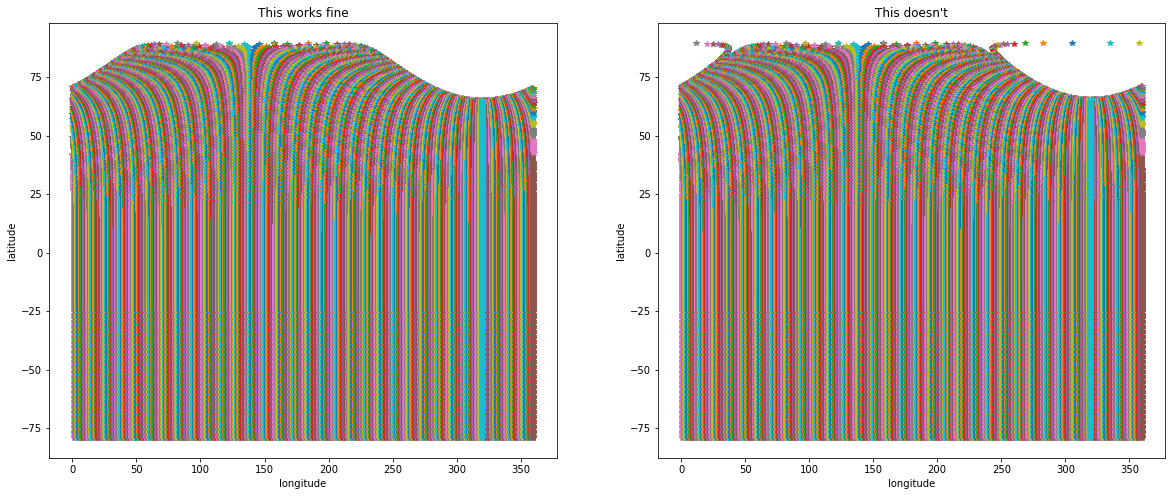

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
im = ax1.plot(poplon[:367, :], poplat[:367, :], '*')
ax1.set_ylabel('latitude')
ax1.set_xlabel('longitude')
ax1.set_title('This works fine')

im2 = ax2.plot(poplon[:368, :], poplat[:368, :], '*')
ax2.set_ylabel('latitude')
ax2.set_xlabel('longitude')
ax2.set_title("This doesn't")

## Armed with this new knowledge, lets try again. Below I subset the array I'm  plotting to the extents shown in the figure above.
## You'll see the left one works, while the right one doesn't.

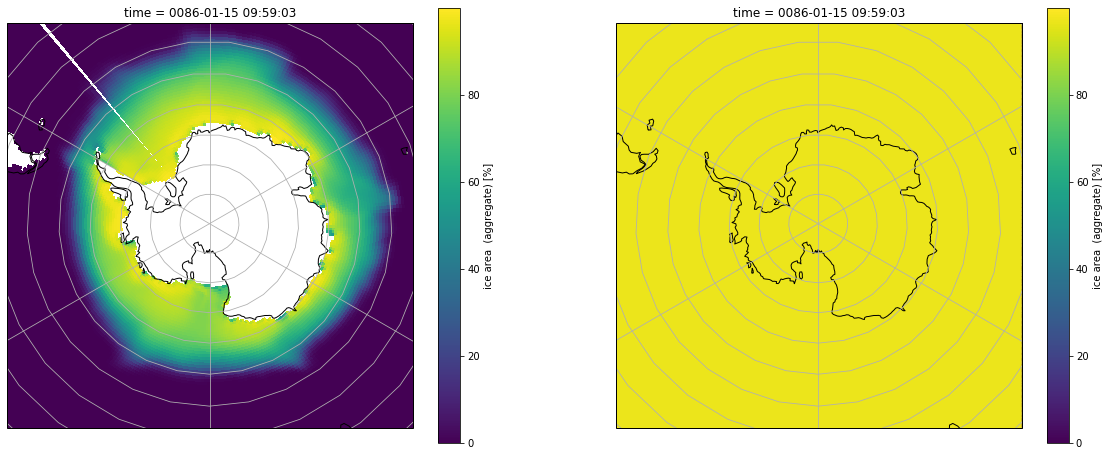

In [8]:
fig2 = plt.figure(2, figsize=(20, 8))
ax1 = fig2.add_subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax1.coastlines()
ax1.gridlines()
ax1.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
im1 = aice[:367, :].plot.pcolormesh('TLON', 'TLAT', ax=ax1, transform=ccrs.PlateCarree())

ax2 = fig2.add_subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
ax2.coastlines()
ax2.gridlines()
ax2.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
im2 = aice[:368, :].plot.pcolormesh('TLON', 'TLAT', ax=ax2, transform=ccrs.PlateCarree())

## All is well again. Or is it? what if we try a contourf?

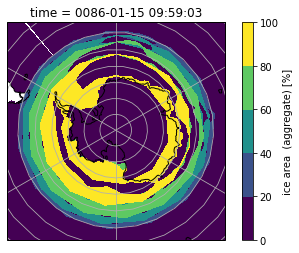

In [9]:
fig2 = plt.figure(2)
axs = plt.axes(projection=ccrs.SouthPolarStereo())
axs.coastlines()
axs.gridlines()
axs.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
im = aice[:367, :].plot.contourf('TLON', 'TLAT', ax=axs, transform=ccrs.PlateCarree())

## It'll be tough to get that one past the Nature editors

## This time, the issue is that, for some reason, the CICE and POP grids don't have monotonically increasing longitudes. They start at 320E. Because, why not?  
## Fortunately, `xarray` has a `sortby` method which can sort a DataArray according to some data that matches one of the dimensions that you feed it. Note the data you're using to sort by needs to be 1-D  
## on the POP grid, the longitudes in the Southern Hemisphere don't curve like they do in the Northern Hemisphere, so if we sort by the first row of longitudes, it fixes the issue. Note we also don't need to subset the data for contourf. It doesn't seem to have the same problem as pcolormesh

In [11]:
aice_sorted = aice.sortby(aice.TLON[0, :])

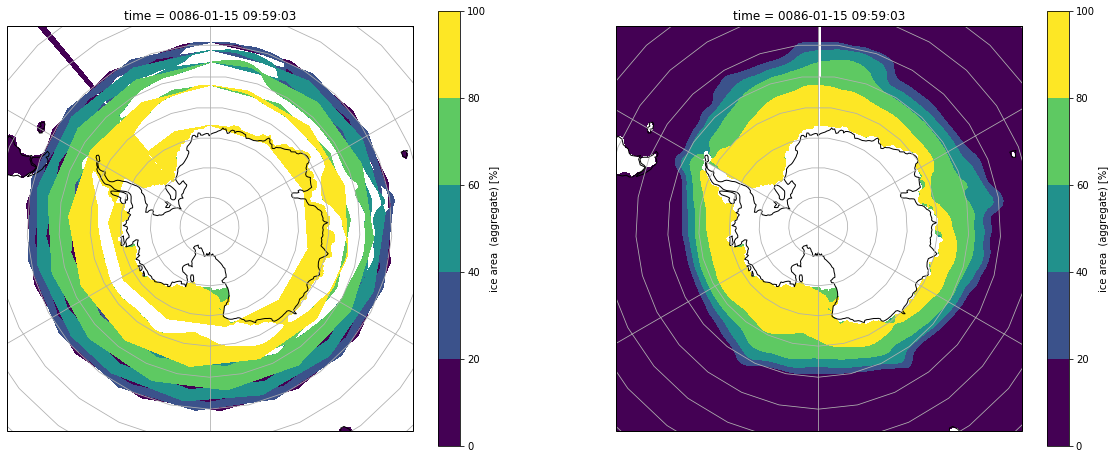

In [12]:
fig2 = plt.figure(2, figsize=(20, 8))
ax1 = fig2.add_subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax1.coastlines()
ax1.gridlines()
ax1.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
im1 = aice.plot.contourf('TLON', 'TLAT', ax=ax1, transform=ccrs.PlateCarree())

ax2 = fig2.add_subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
ax2.coastlines()
ax2.gridlines()
ax2.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
im2 = aice_sorted.plot.contourf('TLON', 'TLAT', ax=ax2, transform=ccrs.PlateCarree())

## Much better, although this only seems to work for the Southern Hemisphere. Due to the weird pole hole its not possible to sort the grid to make contourf work at the North Pole as far as I can tell. You'll probably need to regrid and then contourf

Text(0.5, 1.0, 'pcolormesh')

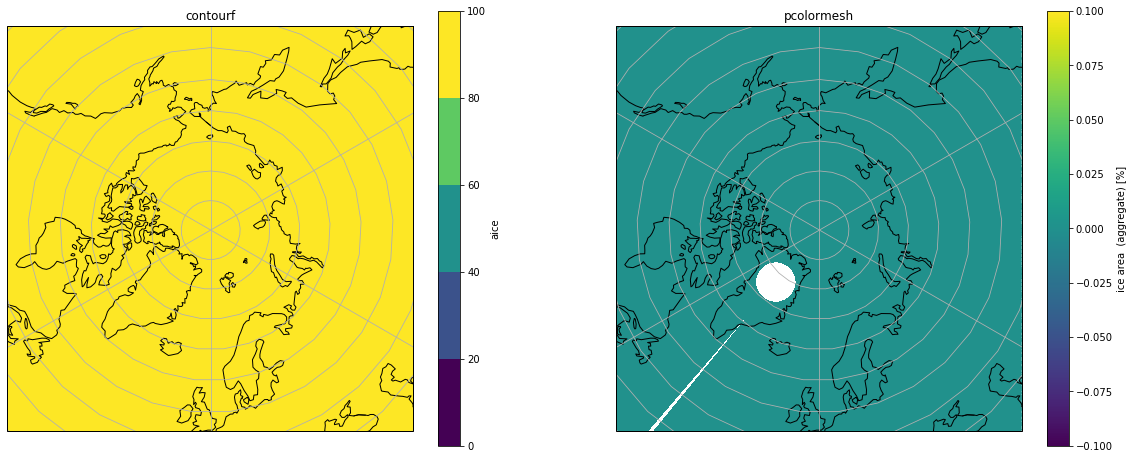

In [21]:
aice_sorted2 = xr.apply_ufunc(np.nan_to_num, aice_sorted)
aice_sorted2 = aice_sorted2[-100:, :].sortby(aice_sorted2.TLON[-1, :])

fig2 = plt.figure(2, figsize=(20, 8))
ax1 = fig2.add_subplot(1, 2, 1, projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.gridlines()
ax1.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
im1 = aice_sorted2.plot.contourf('TLON', 'TLAT', ax=ax1, transform=ccrs.PlateCarree())
ax1.set_title('contourf')

ax2 = fig2.add_subplot(1, 2, 2, projection=ccrs.NorthPolarStereo())
ax2.coastlines()
ax2.gridlines()
ax2.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
im2 = aice.plot.pcolormesh('TLON', 'TLAT', ax=ax2, transform=ccrs.PlateCarree())
ax2.set_title('pcolormesh')

In [17]:
aice_sorted2

<xarray.DataArray 'aice' (nj: 384, ni: 320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     object 0086-01-15 09:59:03
Dimensions without coordinates: nj, ni
Attributes:
    units:          %
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    comment:        none
    cell_methods:   time: mean
    time_rep:       averaged

In [63]:
def sortlons(data):
    lon = data.TLON
    
    datacopy = data.copy(deep=True)
    
    dataout = np.zeros(data.shape)
    lonout = np.zeros(lon.shape)
    
    for x in range(data.shape[0]):
        row = data[x, :]
        lonrow = lon[x, :]
        lonsorted = np.sort(lonrow)
        row_sorted = row.sortby(lon[x, :])
        dataout[x, :] = row_sorted
        lonout[x, :] = lonsorted
        
    
    datacopy[:] = dataout
    datacopy = datacopy.assign_coords({'TLON': (('nj', 'ni'), lonout)})
    
    return datacopy

print(aice)
test = aice[-100:, :]

testout = sortlons(test)
        
    


<xarray.DataArray 'aice' (nj: 384, ni: 320)>
[122880 values with dtype=float32]
Coordinates:
    time     object 0086-01-15 09:59:03
    TLON     (nj, ni) float32 ...
    TLAT     (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Attributes:
    units:          %
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    comment:        none
    cell_methods:   time: mean
    time_rep:       averaged


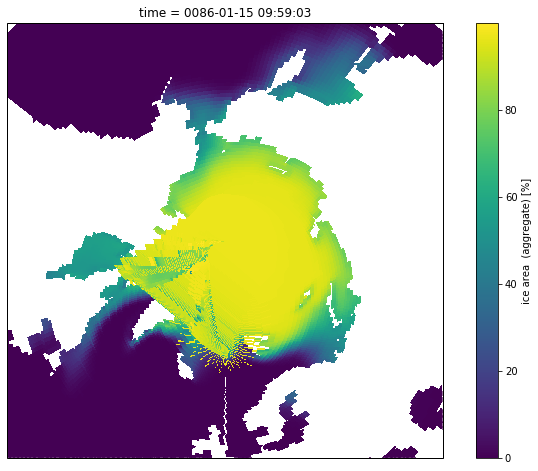

In [64]:
fig = plt.figure(1, figsize=(12, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
testout.plot.pcolormesh('TLON', 'TLAT', ax=axs, transform=ccrs.PlateCarree())

In [45]:
np.sort()

array([302.65372, 302.65662, 302.65738, 302.66617, 302.6675 , 302.68243,
       302.68402, 302.7055 , 302.70688, 302.73547, 302.73593, 302.77118,
       302.77237, 302.81244, 302.8163 , 302.8597 , 302.86737, 302.9129 ,
       302.9256 , 302.9719 , 302.99112, 303.03662, 303.06393, 303.107  ,
       303.14417, 303.18295, 303.23187, 303.2644 , 303.32712, 303.3513 ,
       303.42993, 303.44348, 303.54044, 303.54092, 303.64352, 303.65863,
       303.75122, 303.7846 , 303.86395, 303.9184 , 303.9816 , 304.06006,
       304.1041 , 304.20963, 304.23138, 304.36337, 304.36713, 304.49997,
       304.53262, 304.6411 , 304.70615, 304.78674, 304.88766, 304.93674,
       305.07727, 305.09106, 305.24963, 305.27496, 305.41238, 305.4807 ,
       305.57922, 305.69452, 305.7501 , 305.9164 , 305.9249 , 306.10358,
       306.14636, 306.28607, 306.38434, 306.47226, 306.63034, 306.66214,
       306.8556 , 306.8843 , 307.05258, 307.1462 , 307.253  , 307.416  ,
       307.4568 , 307.66388, 307.69354, 307.8742 , 